In [305]:
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

In [241]:
df = pd.read_csv('train.csv', sep=',')

In [242]:
df

id        date    country                 store  \
0            0  2010-01-01     Canada     Discount Stickers   
1            1  2010-01-01     Canada     Discount Stickers   
2            2  2010-01-01     Canada     Discount Stickers   
3            3  2010-01-01     Canada     Discount Stickers   
4            4  2010-01-01     Canada     Discount Stickers   
...        ...         ...        ...                   ...   
230125  230125  2016-12-31  Singapore  Premium Sticker Mart   
230126  230126  2016-12-31  Singapore  Premium Sticker Mart   
230127  230127  2016-12-31  Singapore  Premium Sticker Mart   
230128  230128  2016-12-31  Singapore  Premium Sticker Mart   
230129  230129  2016-12-31  Singapore  Premium Sticker Mart   

                   product  num_sold  
0        Holographic Goose       NaN  
1                   Kaggle     973.0  
2             Kaggle Tiers     906.0  
3                 Kerneler     423.0  
4       Kerneler Dark Mode     491.0  
...                    ...       ...  
230125   Holographic Goose     466.0  
230126              Kaggle    2907.0  
230127        Kaggle Tiers    2299.0  
230128            Kerneler    1242.0  
230129  Kerneler Dark Mode    1622.0  

[230130 rows x 6 columns]

In [243]:
df.loc[df.duplicated()]

Empty DataFrame
Columns: [id, date, country, store, product, num_sold]
Index: []

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [245]:
df['date'] = pd.to_datetime(df['date'])

In [246]:
df.describe(include="O").T

count unique                top   freq
country  230130      6             Canada  38355
store    230130      3  Discount Stickers  76710
product  230130      5  Holographic Goose  46026

In [248]:
df[df['country']=='Canada']

id       date country                 store             product  \
0            0 2010-01-01  Canada     Discount Stickers   Holographic Goose   
1            1 2010-01-01  Canada     Discount Stickers              Kaggle   
2            2 2010-01-01  Canada     Discount Stickers        Kaggle Tiers   
3            3 2010-01-01  Canada     Discount Stickers            Kerneler   
4            4 2010-01-01  Canada     Discount Stickers  Kerneler Dark Mode   
...        ...        ...     ...                   ...                 ...   
230050  230050 2016-12-31  Canada  Premium Sticker Mart   Holographic Goose   
230051  230051 2016-12-31  Canada  Premium Sticker Mart              Kaggle   
230052  230052 2016-12-31  Canada  Premium Sticker Mart        Kaggle Tiers   
230053  230053 2016-12-31  Canada  Premium Sticker Mart            Kerneler   
230054  230054 2016-12-31  Canada  Premium Sticker Mart  Kerneler Dark Mode   

        num_sold  
0            NaN  
1          973.0  
2          906.0  
3          423.0  
4          491.0  
...          ...  
230050     309.0  
230051    2170.0  
230052    1711.0  
230053     938.0  
230054    1113.0  

[38355 rows x 6 columns]

In [249]:
df.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [250]:
bool1 = pd.isnull(df['num_sold']) & (df['product'] == 'Holographic Goose')
df[bool1]

id       date country              store            product  \
0            0 2010-01-01  Canada  Discount Stickers  Holographic Goose   
45          45 2010-01-01   Kenya  Discount Stickers  Holographic Goose   
90          90 2010-01-02  Canada  Discount Stickers  Holographic Goose   
135        135 2010-01-02   Kenya  Discount Stickers  Holographic Goose   
180        180 2010-01-03  Canada  Discount Stickers  Holographic Goose   
...        ...        ...     ...                ...                ...   
229905  229905 2016-12-29   Kenya  Discount Stickers  Holographic Goose   
229950  229950 2016-12-30  Canada  Discount Stickers  Holographic Goose   
229995  229995 2016-12-30   Kenya  Discount Stickers  Holographic Goose   
230040  230040 2016-12-31  Canada  Discount Stickers  Holographic Goose   
230085  230085 2016-12-31   Kenya  Discount Stickers  Holographic Goose   

        num_sold  
0            NaN  
45           NaN  
90           NaN  
135          NaN  
180          NaN  
...          ...  
229905       NaN  
229950       NaN  
229995       NaN  
230040       NaN  
230085       NaN  

[8806 rows x 6 columns]

In [251]:
bool2 = pd.isnull(df['num_sold']) & (df['product'] != 'Holographic Goose')
df[bool2]

id       date country              store   product  num_sold
1128      1128 2010-01-13   Kenya  Discount Stickers  Kerneler       NaN
3108      3108 2010-02-04   Kenya  Discount Stickers  Kerneler       NaN
3558      3558 2010-02-09   Kenya  Discount Stickers  Kerneler       NaN
3738      3738 2010-02-11   Kenya  Discount Stickers  Kerneler       NaN
4098      4098 2010-02-15   Kenya  Discount Stickers  Kerneler       NaN
...        ...        ...     ...                ...       ...       ...
41988    41988 2011-04-12   Kenya  Discount Stickers  Kerneler       NaN
42078    42078 2011-04-13   Kenya  Discount Stickers  Kerneler       NaN
42708    42708 2011-04-20   Kenya  Discount Stickers  Kerneler       NaN
45048    45048 2011-05-16   Kenya  Discount Stickers  Kerneler       NaN
207003  207003 2016-04-19  Canada  Discount Stickers  Kerneler       NaN

[65 rows x 6 columns]

In [252]:
bool3 = pd.isnull(df['num_sold']) & (df['product'] != 'Holographic Goose') & (df['product'] !='Kerneler')
df[bool3]

id       date country              store             product  \
23719  23719 2010-09-21   Kenya  Discount Stickers  Kerneler Dark Mode   

       num_sold  
23719       NaN

In [253]:
bool3 = pd.isnull(df['num_sold']) & (df['product'] == 'Holographic Goose') & (df['store'] !='Discount Stickers')
df[bool3]

id       date country                 store            product  \
320        320 2010-01-04   Kenya     Stickers for Less  Holographic Goose   
410        410 2010-01-05   Kenya     Stickers for Less  Holographic Goose   
500        500 2010-01-06   Kenya     Stickers for Less  Holographic Goose   
505        505 2010-01-06   Kenya  Premium Sticker Mart  Holographic Goose   
545        545 2010-01-07  Canada     Stickers for Less  Holographic Goose   
...        ...        ...     ...                   ...                ...   
228605  228605 2016-12-15  Canada     Stickers for Less  Holographic Goose   
228965  228965 2016-12-19  Canada     Stickers for Less  Holographic Goose   
229055  229055 2016-12-20  Canada     Stickers for Less  Holographic Goose   
229325  229325 2016-12-23  Canada     Stickers for Less  Holographic Goose   
229415  229415 2016-12-24  Canada     Stickers for Less  Holographic Goose   

        num_sold  
320          NaN  
410          NaN  
500          NaN  
505          NaN  
545          NaN  
...          ...  
228605       NaN  
228965       NaN  
229055       NaN  
229325       NaN  
229415       NaN  

[3692 rows x 6 columns]

In [254]:
df['num_sold']=df['num_sold'].fillna(df.groupby(['country','store','product'])['num_sold'].transform('mean'))

In [268]:
bool3 = (df['product'] == 'Holographic Goose') & (df['store'] !='Discount Stickers') & (df['country']== 'Canada')
df[bool3].head(30)

id       date country                 store            product  \
5        5 2010-01-01  Canada     Stickers for Less  Holographic Goose   
10      10 2010-01-01  Canada  Premium Sticker Mart  Holographic Goose   
95      95 2010-01-02  Canada     Stickers for Less  Holographic Goose   
100    100 2010-01-02  Canada  Premium Sticker Mart  Holographic Goose   
185    185 2010-01-03  Canada     Stickers for Less  Holographic Goose   
190    190 2010-01-03  Canada  Premium Sticker Mart  Holographic Goose   
275    275 2010-01-04  Canada     Stickers for Less  Holographic Goose   
280    280 2010-01-04  Canada  Premium Sticker Mart  Holographic Goose   
365    365 2010-01-05  Canada     Stickers for Less  Holographic Goose   
370    370 2010-01-05  Canada  Premium Sticker Mart  Holographic Goose   
455    455 2010-01-06  Canada     Stickers for Less  Holographic Goose   
460    460 2010-01-06  Canada  Premium Sticker Mart  Holographic Goose   
545    545 2010-01-07  Canada     Stickers for Less  Holographic Goose   
550    550 2010-01-07  Canada  Premium Sticker Mart  Holographic Goose   
635    635 2010-01-08  Canada     Stickers for Less  Holographic Goose   
640    640 2010-01-08  Canada  Premium Sticker Mart  Holographic Goose   
725    725 2010-01-09  Canada     Stickers for Less  Holographic Goose   
730    730 2010-01-09  Canada  Premium Sticker Mart  Holographic Goose   
815    815 2010-01-10  Canada     Stickers for Less  Holographic Goose   
820    820 2010-01-10  Canada  Premium Sticker Mart  Holographic Goose   
905    905 2010-01-11  Canada     Stickers for Less  Holographic Goose   
910    910 2010-01-11  Canada  Premium Sticker Mart  Holographic Goose   
995    995 2010-01-12  Canada     Stickers for Less  Holographic Goose   
1000  1000 2010-01-12  Canada  Premium Sticker Mart  Holographic Goose   
1085  1085 2010-01-13  Canada     Stickers for Less  Holographic Goose   
1090  1090 2010-01-13  Canada  Premium Sticker Mart  Holographic Goose   
1175  1175 2010-01-14  Canada     Stickers for Less  Holographic Goose   
1180  1180 2010-01-14  Canada  Premium Sticker Mart  Holographic Goose   
1265  1265 2010-01-15  Canada     Stickers for Less  Holographic Goose   
1270  1270 2010-01-15  Canada  Premium Sticker Mart  Holographic Goose   

        num_sold  
5     300.000000  
10    375.000000  
95    281.000000  
100   336.000000  
185   297.000000  
190   338.000000  
275   235.000000  
280   277.000000  
365   240.000000  
370   287.000000  
455   223.000000  
460   276.000000  
545   228.816653  
550   240.000000  
635   208.000000  
640   265.000000  
725   221.000000  
730   274.000000  
815   245.000000  
820   288.000000  
905   228.816653  
910   242.000000  
995   200.000000  
1000  243.000000  
1085  202.000000  
1090  215.000000  
1175  228.816653  
1180  225.000000  
1265  217.000000  
1270  232.000000

In [270]:
df.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    5114
dtype: int64

In [272]:
# Identyfikacja grup z brakami
nan_groups = df.groupby(['country', 'store', 'product']).apply(
    lambda x: x['num_sold'].isna().all()
)

problematic_groups = nan_groups[nan_groups].index

print("Grupy z samymi NaN w kolumnie 'num_sold':")
print(problematic_groups)

Grupy z samymi NaN w kolumnie 'num_sold':
MultiIndex([('Canada', 'Discount Stickers', 'Holographic Goose'),
            ( 'Kenya', 'Discount Stickers', 'Holographic Goose')],
           names=['country', 'store', 'product'])


In [274]:
# Interpolacja w obrębie grupy 'country' i 'store' za pomocą transformacji
df['num_sold'] = df.groupby(['country', 'store'])['num_sold'].transform(
    lambda group: group.interpolate(method='linear', limit_direction='both', axis=0)
)


In [276]:
df

id       date    country                 store  \
0            0 2010-01-01     Canada     Discount Stickers   
1            1 2010-01-01     Canada     Discount Stickers   
2            2 2010-01-01     Canada     Discount Stickers   
3            3 2010-01-01     Canada     Discount Stickers   
4            4 2010-01-01     Canada     Discount Stickers   
...        ...        ...        ...                   ...   
230125  230125 2016-12-31  Singapore  Premium Sticker Mart   
230126  230126 2016-12-31  Singapore  Premium Sticker Mart   
230127  230127 2016-12-31  Singapore  Premium Sticker Mart   
230128  230128 2016-12-31  Singapore  Premium Sticker Mart   
230129  230129 2016-12-31  Singapore  Premium Sticker Mart   

                   product  num_sold  
0        Holographic Goose     973.0  
1                   Kaggle     973.0  
2             Kaggle Tiers     906.0  
3                 Kerneler     423.0  
4       Kerneler Dark Mode     491.0  
...                    ...       ...  
230125   Holographic Goose     466.0  
230126              Kaggle    2907.0  
230127        Kaggle Tiers    2299.0  
230128            Kerneler    1242.0  
230129  Kerneler Dark Mode    1622.0  

[230130 rows x 6 columns]

In [278]:
bool3 = pd.isnull(df['num_sold']) & (df['product'] == 'Holographic Goose') & (df['store'] == 'Discount Stickers')  & (df['country'] == 'Kenya') 
df[bool3]

Empty DataFrame
Columns: [id, date, country, store, product, num_sold]
Index: []

In [291]:
bool3 = (df['product'] == 'Holographic Goose') & (df['store'] == 'Discount Stickers')  & (df['country'] == 'Kenya') 
df[bool3]

id       date country              store            product  \
45          45 2010-01-01   Kenya  Discount Stickers  Holographic Goose   
135        135 2010-01-02   Kenya  Discount Stickers  Holographic Goose   
225        225 2010-01-03   Kenya  Discount Stickers  Holographic Goose   
315        315 2010-01-04   Kenya  Discount Stickers  Holographic Goose   
405        405 2010-01-05   Kenya  Discount Stickers  Holographic Goose   
...        ...        ...     ...                ...                ...   
229725  229725 2016-12-27   Kenya  Discount Stickers  Holographic Goose   
229815  229815 2016-12-28   Kenya  Discount Stickers  Holographic Goose   
229905  229905 2016-12-29   Kenya  Discount Stickers  Holographic Goose   
229995  229995 2016-12-30   Kenya  Discount Stickers  Holographic Goose   
230085  230085 2016-12-31   Kenya  Discount Stickers  Holographic Goose   

        num_sold  
45          20.0  
135         12.5  
225         14.0  
315         12.0  
405         11.5  
...          ...  
229725      16.5  
229815      19.5  
229905      19.5  
229995      21.5  
230085      21.0  

[2557 rows x 6 columns]

In [289]:
bool4 =(df['product'] == 'Holographic Goose') & (df['store'] == 'Discount Stickers')  & (df['country'] == 'Canada') 
df[bool4]

id       date country              store            product  \
0            0 2010-01-01  Canada  Discount Stickers  Holographic Goose   
90          90 2010-01-02  Canada  Discount Stickers  Holographic Goose   
180        180 2010-01-03  Canada  Discount Stickers  Holographic Goose   
270        270 2010-01-04  Canada  Discount Stickers  Holographic Goose   
360        360 2010-01-05  Canada  Discount Stickers  Holographic Goose   
...        ...        ...     ...                ...                ...   
229680  229680 2016-12-27  Canada  Discount Stickers  Holographic Goose   
229770  229770 2016-12-28  Canada  Discount Stickers  Holographic Goose   
229860  229860 2016-12-29  Canada  Discount Stickers  Holographic Goose   
229950  229950 2016-12-30  Canada  Discount Stickers  Holographic Goose   
230040  230040 2016-12-31  Canada  Discount Stickers  Holographic Goose   

        num_sold  
0          973.0  
90         686.0  
180        720.0  
270        619.5  
360        574.0  
...          ...  
229680     530.0  
229770     591.0  
229860     640.0  
229950     690.5  
230040     686.0  

[2557 rows x 6 columns]

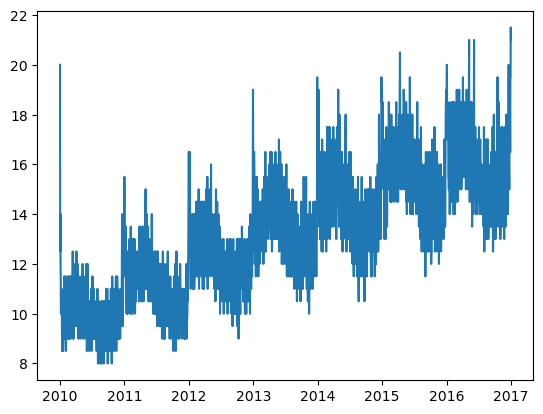

In [293]:
plt.plot(df.date[bool3],df.num_sold[bool3])

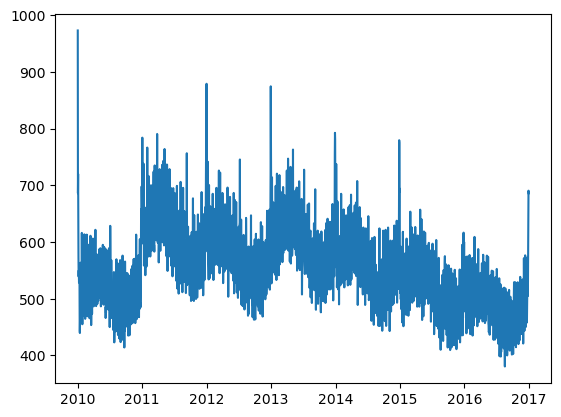

In [295]:
plt.plot(df.date[bool4],df.num_sold[bool4])

In [297]:
df.isnull().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [299]:
print(df['country'].unique())
print(df['store'].unique())
print(df['product'].unique())
dff=df.copy()

['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


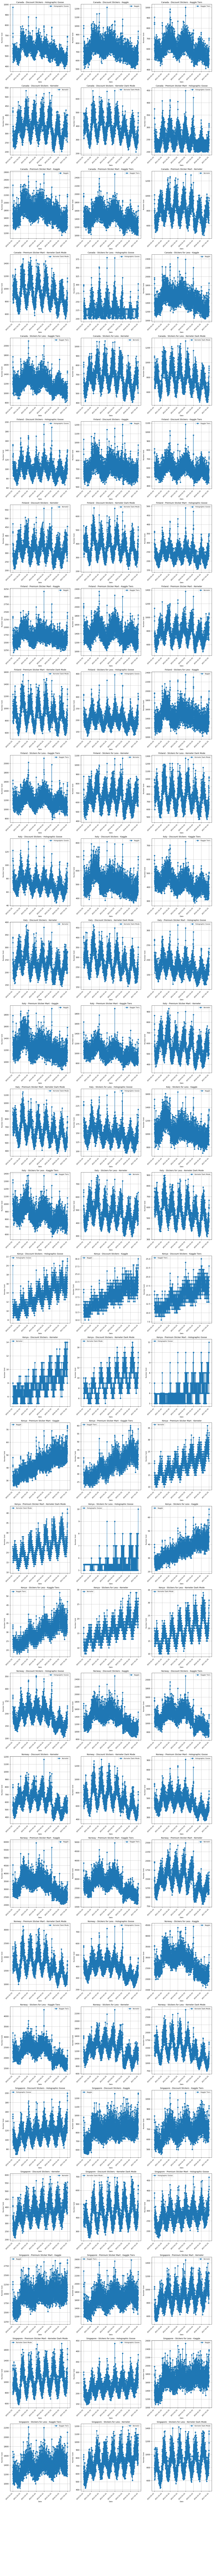

In [301]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

grouped = df.groupby(['country', 'store', 'product'])
n_groups = len(grouped)

# Set up subplots
fig, axes = plt.subplots(nrows=(n_groups // 3 + 1), ncols=3, figsize=(15, n_groups * 2))
axes = axes.flatten()  # Flatten axes for easy iteration

# Iterate over each group and plot
for ax, ((country, store, product), group) in zip(axes, grouped):
    ax.plot(group['date'], group['num_sold'], label=f'{product}', marker='o')
    ax.set_title(f'{country} - {store} - {product}', fontsize=10)
    ax.set_xlabel('Date', fontsize=8)
    ax.set_ylabel('Number Sold', fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(True)
    
    # Format the x-axis for better readability
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", fontsize=8)

# Remove unused subplots
for ax in axes[len(grouped):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


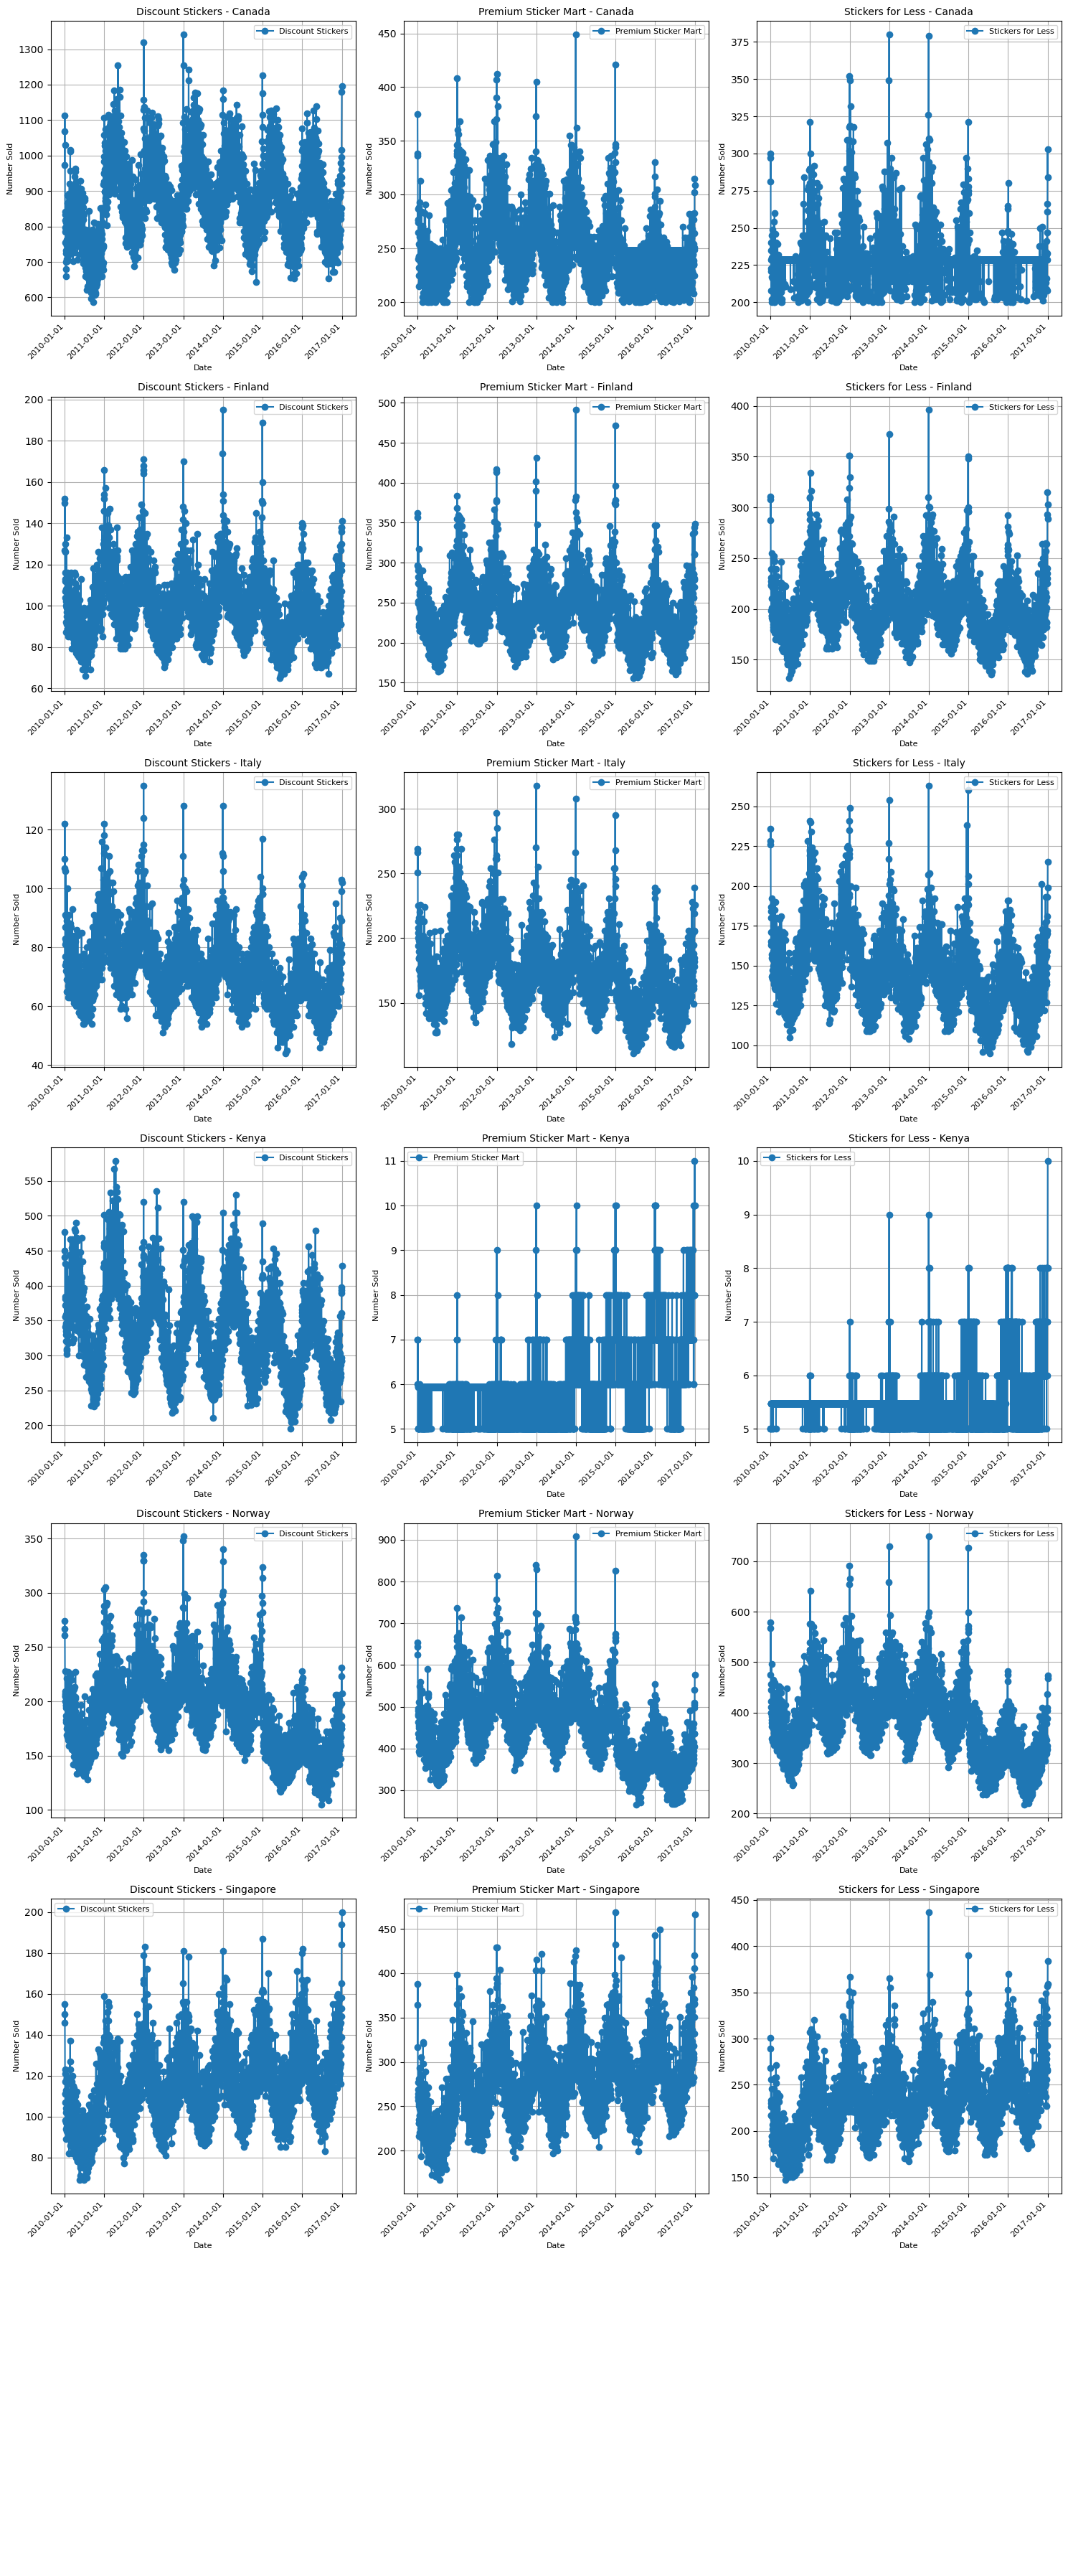

In [137]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Filter the DataFrame for 'Holographic Goose'
df_filtered = df[df['product'] == 'Holographic Goose']

# Sort the filtered DataFrame by 'store' and 'country'
df_filtered = df_filtered.sort_num_solds(by=['store', 'country'])

# Group the filtered DataFrame
grouped = df_filtered.groupby(['country', 'store'])

# Number of groups
n_groups = len(grouped)

# Set up subplots
fig, axes = plt.subplots(nrows=(n_groups // 3 + 1), ncols=3, figsize=(15, n_groups * 2))
axes = axes.flatten()  # Flatten axes for easy iteration

# Iterate over each group and plot
for ax, ((country, store), group) in zip(axes, grouped):
    ax.plot(group['date'], group['num_sold'], label=f'{store}', marker='o')
    ax.set_title(f'{store} - {country}', fontsize=10)
    ax.set_xlabel('Date', fontsize=8)
    ax.set_ylabel('Number Sold', fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(True)
    
    # Format the x-axis for better readability
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", fontsize=8)

# Remove unused subplots
for ax in axes[len(grouped):]:
    ax.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
df = df.sort_values(by=['country', 'store','product'])

groups = df[['country', 'store', 'product']].drop_duplicates().values.tolist()

# Przechowywanie prognoz
final_predictions = {}

for group in groups:
    country, store, product = group
    print(f"Przetwarzanie grupy: Country={country}, Store={store}, Product={product}")
    
    # Filtrowanie danych dla danej grupy
    df_group = df[(df['country'] == country) & 
                  (df['store'] == store) & 
                  (df['product'] == product)].copy()
    df_group.set_index('date', inplace=True)
    
    if len(df_group) < 20:  # Sprawdzenie czy jest wystarczająco danych
        print(f"Pominięto grupę {group} - za mało danych.")
        continue
    
    # Podział na zbiór treningowy i testowy
    train_size = int(len(df_group) * 0.8)
    train, test = df_group.iloc[:train_size], df_group.iloc[train_size:]
    
    # Model SARIMA
    sarima_model = SARIMAX(train['num_sold'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_pred = sarima_fit.forecast(len(test))
    
    # Przygotowanie danych dla XGBoost
    df_group['sarima_pred'] = sarima_fit.predict(start=train.index[0], end=test.index[-1])
    df_group.dropna(inplace=True)
    
    X = df_group[['sarima_pred']]
    y = df_group['num_sold']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Model XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    
    # Przygotowanie danych dla LSTM
    seq_length = 10
    X_lstm, y_lstm = [], []
    data = y.values
    for i in range(seq_length, len(data)):
        X_lstm.append(data[i-seq_length:i])
        y_lstm.append(data[i])
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
    
    # Model LSTM
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_lstm, y_lstm, epochs=20, batch_size=16, verbose=0)
    
    lstm_pred = model.predict(X_lstm[-len(test):])[:, 0]
    
    # Łączenie prognoz (średnia ważona)
    final_pred = (0.5 * sarima_pred.values + 0.3 * xgb_pred + 0.2 * lstm_pred)
    
    # Ocena modelu
    mae = mean_absolute_error(test['num_sold'], final_pred)
    print(f"Grupa {group} - MAE: {mae:.4f}")
    
    final_predictions[group] = final_pred

# Wyniki finalnych prognoz dla każdej grupy
print(final_predictions)

Przetwarzanie grupy: Country=Canada, Store=Discount Stickers, Product=Holographic Goose


In [60]:
data = pd.read_csv('train.csv', sep=',')
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['date'] = (data['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')  # Liczba dni od 1 stycznia 1970

# Konwertowanie tekstowych kolumn na numeryczne
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    if column != 'date':  # Nie kodujemy daty
        data[column] = label_encoder.fit_transform(data[column].astype(str))

id   date  country  store  product     num_sold
0            0  14610        0      0        0   645.339752
1            1  14610        0      0        1   973.000000
2            2  14610        0      0        2   906.000000
3            3  14610        0      0        3   423.000000
4            4  14610        0      0        4   491.000000
...        ...    ...      ...    ...      ...          ...
230125  230125  17166        5      1        0   466.000000
230126  230126  17166        5      1        1  2907.000000
230127  230127  17166        5      1        2  2299.000000
230128  230128  17166        5      1        3  1242.000000
230129  230129  17166        5      1        4  1622.000000

[230130 rows x 6 columns]

In [123]:
# Konwertowanie tekstowych kolumn na numeryczne
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    if column != 'date':  # Nie kodujemy daty
        data[column] = label_encoder.fit_transform(data[column].astype(str))

In [125]:
def stochastic_regression_imputation(df, target_col):
    # Dane bez braków w kolumnie docelowej
    complete_data = df[df[target_col].notna()]
    missing_data = df[df[target_col].isna()]
    
    # Jeśli nie ma braków, zwróć oryginalny DataFrame
    if missing_data.empty:
        return df
    
    # Zmienna zależna (y) i niezależne (X)
    y = complete_data[target_col]
    X = complete_data.drop(columns=[target_col])
    X = sm.add_constant(X, has_constant='add')  # Dodanie wyrazu wolnego
    
    # Dopasowanie modelu regresji
    model = sm.OLS(y, X).fit()
    
    # Prognoza wartości brakujących
    X_missing = missing_data.drop(columns=[target_col])
    X_missing = sm.add_constant(X_missing, has_constant='add')  # Dodanie wyrazu wolnego
    predictions = model.predict(X_missing)
    
    # Dodanie losowego składnika (reszty z modelu)
    residual_std = model.resid.std()  # Odchylenie standardowe reszt
    stochastic_predictions = predictions + np.random.normal(0, residual_std, size=len(predictions))
    
    # Ograniczenie wartości do >= 0
    stochastic_predictions = np.clip(stochastic_predictions, 0, None)
    
    # Imputacja
     df.loc[df[target_col].isna(), target_col] = stochastic_predictions
    return df
# Imputacja dla danych
data_imputed = stochastic_regression_imputation(data, target_col='num_sold')

data_imputed

id   date  country  store  product     num_sold
0            0  14610        0      0        0   645.339752
1            1  14610        0      0        1   973.000000
2            2  14610        0      0        2   906.000000
3            3  14610        0      0        3   423.000000
4            4  14610        0      0        4   491.000000
...        ...    ...      ...    ...      ...          ...
230125  230125  17166        5      1        0   466.000000
230126  230126  17166        5      1        1  2907.000000
230127  230127  17166        5      1        2  2299.000000
230128  230128  17166        5      1        3  1242.000000
230129  230129  17166        5      1        4  1622.000000

[230130 rows x 6 columns]

In [127]:
min(data_imputed['num_sold'])

-1944.6023508309272